# Identifying Populations at Risk for CHD

by: Zachary Greenberg and Jonathan Silverman

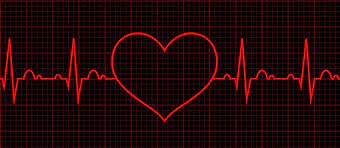

# OVERVIEW

Coronary Heart Disease is the number one leading cause of death among Americans. This project investigates some health factors that could increase the risk of CHD. With this knowledge, preventative actions can be taken by those most at risk improving their quality of life and lowering future healthcare costs. Our findings come from a public dataset on Kaggle including patient's information in a longterm cardiovascular study. We are attempting to build a model that will help identify the leading risk factors for CHD. Our performance metric is the recall score as we value the minimization of false negatives. We plan to evaluate Logistic Regression, Decision Tree, and Random Forest models as we hope their interpretability will serve us well.

# BUSINESS UNDERSTANDING

Coronary Heart Disease is a serious illness. It is the #1 leading cause of death among Americans. According to the CDC, Heart Disease cost the US about $214 billion in 2015 and is increasing annually. We are seeking insight on the factors that put people at risk for CHD. The intuition we gain we hope will prove to be valuable. By identifying populations at risk and selecting them for interventions they will lower health care costs down the line and become much healthier human beings. 

# DATA UNDERSTANDING

The data is from a publicly available dataset on Kaggle from an ongoing cardiovascular study in Framingham, Massachusetts. It is a combination of categorical and continuous bits of patient's health information. Our target variable is the column 'TenYearCHD', which is a categorical variable determining a yes or no risk of CHD. 

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading in the data
df = pd.read_csv('Data/data.csv')

In [3]:
df.head(2)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0


In [4]:
df.dtypes.head(2)

id     int64
age    int64
dtype: object

The id column is not a risk factor, so we will drop it.

In [5]:
df.drop('id', axis = 1, inplace = True)

In [6]:
df.shape

(3390, 16)

There are 15 features in this dataset -the 16th column is the target variable- that we can utilize for evaluation. There is a total of 3390 rows meaning there are 3390 participants in the study.

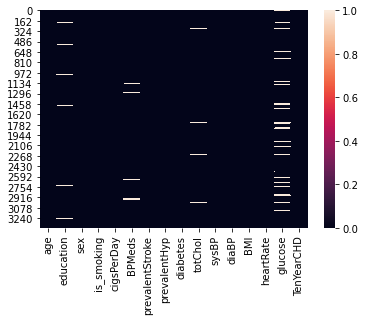

In [7]:
#checking for missing values
sns.heatmap(df.isnull());

There are definitely some missing values that need to be accounted for. We will deal with them when we get to the data cleaning process.

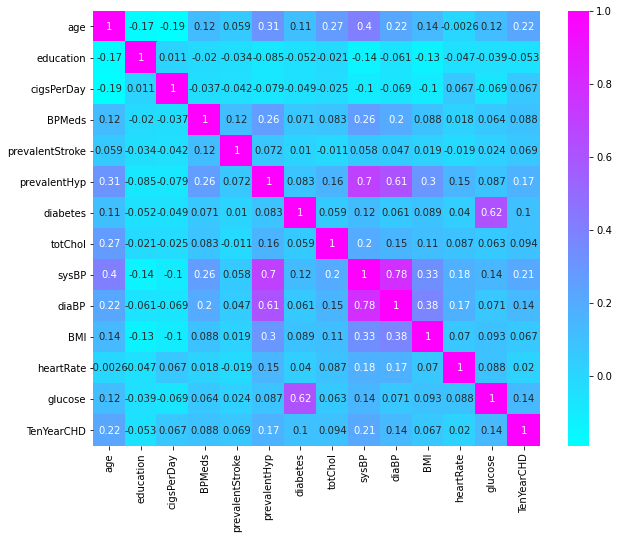

In [8]:
#checking the correlation between variables
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='cool');

We have decided on a threshold of .75 for multicollinearity, the two variables that violate this assumption are systolic and diastolic blood pressure. After some research we have decided to eliminate diastolic blood pressure because studies have shown there is a greater risk of heart disease with higher systolic blood pressure.

In [9]:
df.drop('diaBP', axis = 1, inplace = True)

After careful consideration, we also decided to drop the BPMeds column as we feared it may contribute to False negative results.

In [10]:
df.drop('BPMeds', axis = 1, inplace = True)

In [11]:
df.TenYearCHD.value_counts()

0    2879
1     511
Name: TenYearCHD, dtype: int64

The dataset is clearly imbalanced. The majority of the dataset is at NO risk of CHD. We will try to address this issue below.

# DATA PREPARATION

### Categorical Variables

> *EDUCATION* - Categorical

According to the documentation this is how the education column is categorized:

1 = Some High School
2 = High School or GED
3 = Some College or Vocational School
4 = College

In [12]:
df.education.value_counts()

1.0    1391
2.0     990
3.0     549
4.0     373
Name: education, dtype: int64

In [13]:
df.education.isnull().sum()

87

In [14]:
#This is the percent of missing values in the EDUCATION column
df.education.isnull().sum() / df.shape[0]

0.02566371681415929

In [15]:
#imputing missing values with mode
df.education.fillna(1.0, inplace = True)

We decided to impute the missing values with the mode because this is a categorical column.

In [16]:
#turning education into a categorical column
df.education = df.education.astype('object')

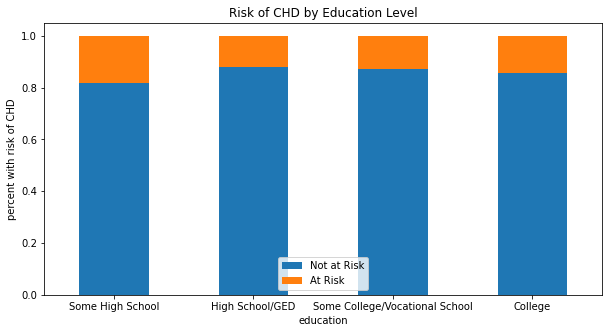

In [17]:
#graphing education with target variable
legend_labels = ['Not at Risk', 'At Risk']
edu_labels = ['Some High School', 'High School/GED', 'Some College/Vocational School', 'College']
fig, ax = plt.subplots(figsize=(10,5))
df.groupby('education')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_xticklabels(edu_labels, rotation= 360)
ax.set_title('Risk of CHD by Education Level')
ax.legend(legend_labels, loc='lower center');

Those who have reported Some High School for their education level seem to be the ones most at risk for CHD.

> *SEX* - Categorical

In [18]:
df.sex = np.where(df['sex'] == 'M', 1, 0)

In [19]:
df.sex.value_counts()

0    1923
1    1467
Name: sex, dtype: int64

There is a relatively even amount of males and females in this dataset.

In [20]:
#turning sex into a categorical columns
df.sex = df.sex.astype('object')

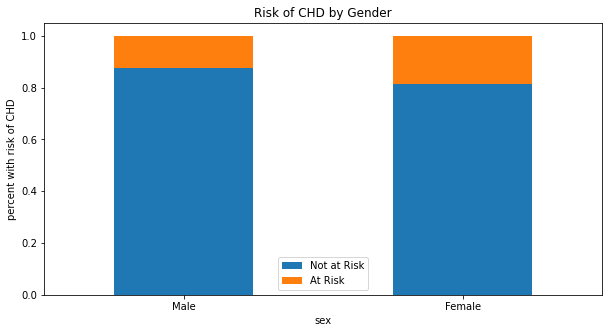

In [21]:
#graphing gender with the target variable
fig, ax = plt.subplots(figsize=(10,5))
df.groupby('sex')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_xticklabels(['Male', 'Female'], rotation= 360)
ax.set_title('Risk of CHD by Gender')
ax.legend(legend_labels, loc='lower center');

From the data, it appears that females are at a slightly higher risk for CHD.

> *SMOKER* - Categorical

In [22]:
#changing the values of the column to numeric
df.is_smoking = np.where(df['is_smoking'] == 'YES', 1, 0)

In [23]:
df.is_smoking.value_counts()

0    1703
1    1687
Name: is_smoking, dtype: int64

There is a fair balance of the amount of people who smoke versus those who don't.

In [24]:
#turning smoking into a categorical column
df.is_smoking = df.is_smoking.astype('object')

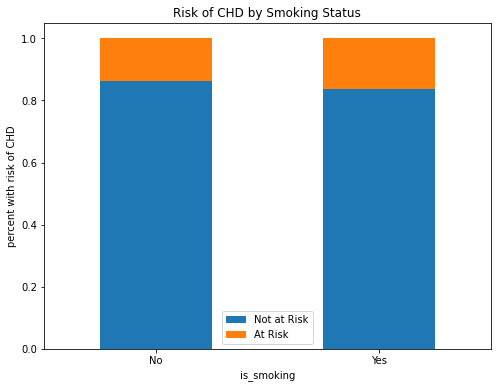

In [25]:
#graphing smoking status and the target variable
fig, ax = plt.subplots(figsize=(8,6))
df.groupby('is_smoking')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Smoking Status')
ax.set_xticklabels(['No', 'Yes'], rotation= 360)
ax.legend(legend_labels, loc='lower center');

The data shows that those who DO smoke are more likely to be at risk for CHD.

> *Stroke* - Categorical

In [26]:
df.prevalentStroke.value_counts()

0    3368
1      22
Name: prevalentStroke, dtype: int64

In [27]:
#turning stroke into a categorical column
df.prevalentStroke = df.prevalentStroke.astype('object')

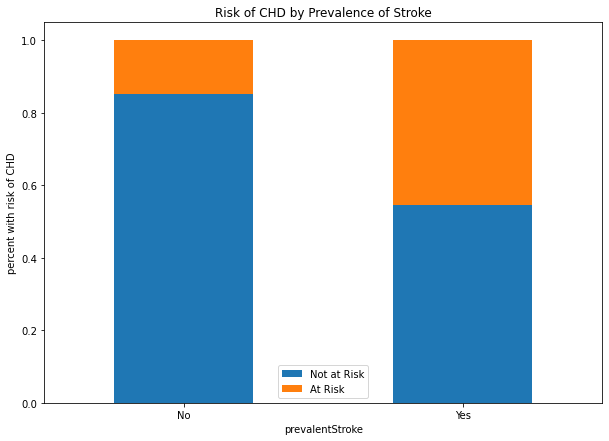

In [28]:
#graphing stroke and target variable
fig, ax = plt.subplots(figsize=(10,7))
df.groupby('prevalentStroke')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Prevalence of Stroke')
ax.set_xticklabels(['No', 'Yes'], rotation= 360)
ax.legend(legend_labels, loc='lower center');

We can see that those who have previously had a stroke are at a higher risk for CHD.

> *Hypertension* - Categorical

In [29]:
df.prevalentHyp.value_counts()

0    2321
1    1069
Name: prevalentHyp, dtype: int64

In [30]:
#turning hypertension into an object variable
df.prevalentHyp = df.prevalentHyp.astype('object')

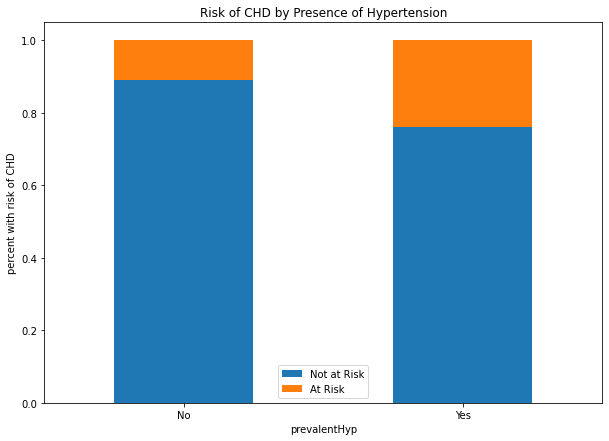

In [31]:
#graphing hypertension and target variable
fig, ax = plt.subplots(figsize=(10,7))
df.groupby('prevalentHyp')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Presence of Hypertension')
ax.set_xticklabels(['No', 'Yes'], rotation= 360)
ax.legend(legend_labels, loc='lower center');

We can see that those who have hypertension are more at risk for CHD.

> *Diabetic* - Categorical

In [32]:
df.diabetes.value_counts()

0    3303
1      87
Name: diabetes, dtype: int64

In [33]:
#making diabetes into a target var
df.diabetes = df.diabetes.astype('object')

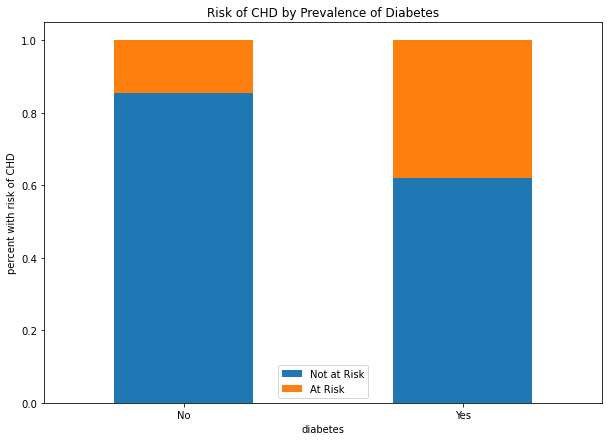

In [34]:
#graphing diabetes vs target var
fig, ax = plt.subplots(figsize=(10,7))
df.groupby('diabetes')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Prevalence of Diabetes')
ax.set_xticklabels(['No', 'Yes'], rotation= 360)
ax.legend(legend_labels, loc='lower center');

We can see that those who are diabetic are more clearly at risk for CHD.

### Continuous Variables

> *AGE* - Continuous

In [35]:
df.age.describe()

count    3390.000000
mean       49.542183
std         8.592878
min        32.000000
25%        42.000000
50%        49.000000
75%        56.000000
max        70.000000
Name: age, dtype: float64

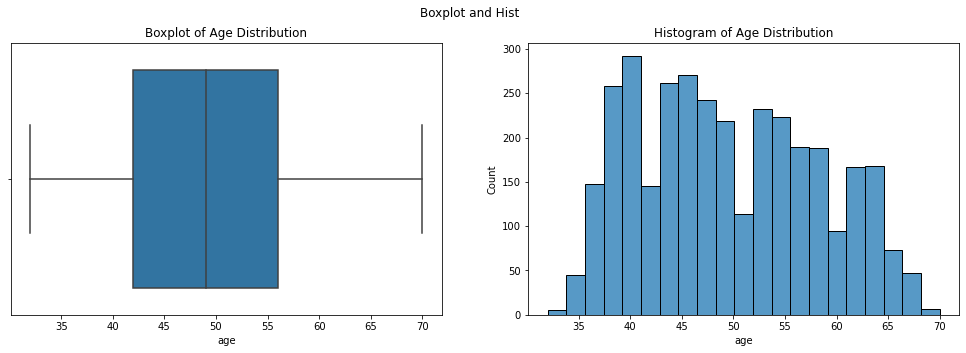

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('Boxplot and Hist')

sns.boxplot(ax=axes[0], x=df.age)
axes[0].set_title('Boxplot of Age Distribution')


sns.histplot(ax=axes[1], x=df.age)
axes[1].set_title('Histogram of Age Distribution');

The distribution of age looks fairly normal. Let's take a look at its relationship to the target variable.

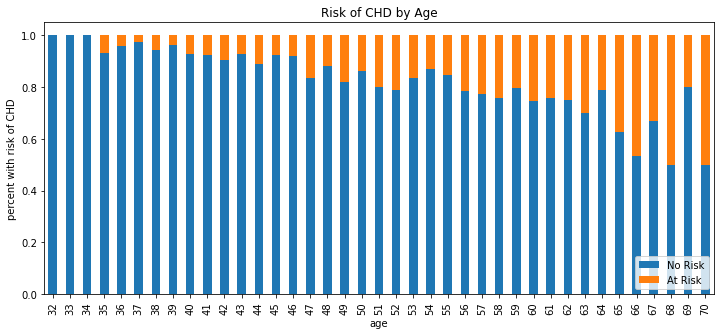

In [37]:
#graphing age with target variable
legend_labels=['No Risk', 'At Risk']
fig, ax = plt.subplots(figsize=(12,5))
df.groupby('age')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Age')
ax.legend(legend_labels, loc='lower right')
plt.savefig('Images/CHDbyAge');


The risk of CHD seems to be greater with age. 

 ***BECAUSE OF THE LARGER RANGES OF THE REMAINING CONTINUOUS VARIABLES, WE DECIDED TO EVALUATE THEIR RELATIONSHIPS WITH THE TARGET, AS WELL AS WITH EACHOTHER, IN A PAIRPLOT DOWN BELOW AFTER SOME CLEANING*** 

> *cigsPerDay* - Continuous

In [38]:
df.cigsPerDay.describe()

count    3368.000000
mean        9.069477
std        11.879078
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        70.000000
Name: cigsPerDay, dtype: float64

In [39]:
df.cigsPerDay.isnull().sum()

22

In [40]:
#mode of cigarettes per day excluding 0.
df[df['cigsPerDay'] != 0]['cigsPerDay'].value_counts().head(1)

20.0    606
Name: cigsPerDay, dtype: int64

In [41]:
#imputing the missing values with the mode of cigarettes excluding 0.
df.cigsPerDay.fillna(20.0, inplace=True)

We figured that people were purposefully obscuring their smoke history perhaps due to peer pressure. We decided to impute these values with the mode excluding 0 cigarettes per day.

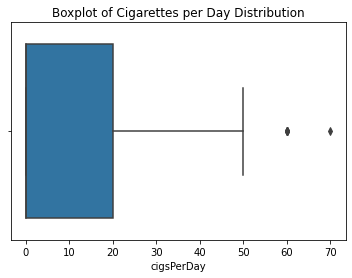

In [42]:
sns.boxplot(df['cigsPerDay'])
plt.title('Boxplot of Cigarettes per Day Distribution');

> *totChol* - Continuous

In [43]:
df.totChol.describe()

count    3352.000000
mean      237.074284
std        45.247430
min       107.000000
25%       206.000000
50%       234.000000
75%       264.000000
max       696.000000
Name: totChol, dtype: float64

In [44]:
df.totChol.isnull().sum()

38

In [45]:
#imputing missing values with the mean
df.totChol.fillna(df.totChol.mean(), inplace = True)

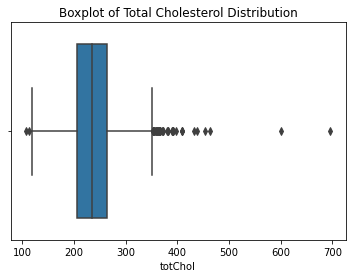

In [46]:
#graphing cholesterol distribution
sns.boxplot(df['totChol'])
plt.title('Boxplot of Total Cholesterol Distribution');

> *Systolic BP* - Continuous

In [47]:
df.sysBP.describe()

count    3390.00000
mean      132.60118
std        22.29203
min        83.50000
25%       117.00000
50%       128.50000
75%       144.00000
max       295.00000
Name: sysBP, dtype: float64

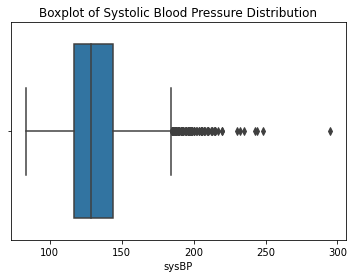

In [48]:
#graphing blood pressure distribution
sns.boxplot(df.sysBP)
plt.title('Boxplot of Systolic Blood Pressure Distribution');

> *BMI* - Continuous

In [49]:
df.BMI.describe()

count    3376.000000
mean       25.794964
std         4.115449
min        15.960000
25%        23.020000
50%        25.380000
75%        28.040000
max        56.800000
Name: BMI, dtype: float64

In [50]:
df.BMI.isnull().sum()

14

In [51]:
#imputing missing values with the mean
df.BMI.fillna(df.BMI.mean(), inplace = True)

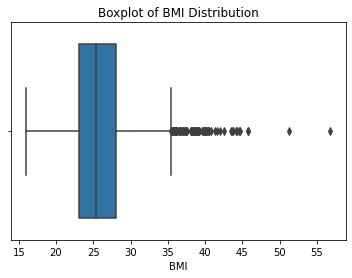

In [52]:
#graphing BMI distribution
sns.boxplot(df.BMI)
plt.title('Boxplot of BMI Distribution');

> *HeartRate* - Continuous

In [53]:
df.heartRate.describe()

count    3389.000000
mean       75.977279
std        11.971868
min        45.000000
25%        68.000000
50%        75.000000
75%        83.000000
max       143.000000
Name: heartRate, dtype: float64

In [54]:
#imputing missing values with the mean
df.heartRate.fillna(df.heartRate.mean(), inplace = True)

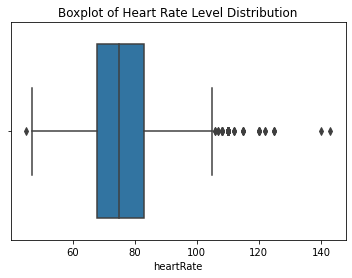

In [55]:
#graphing heart rate distribution
sns.boxplot(df.heartRate)
plt.title('Boxplot of Heart Rate Level Distribution');

> *Glucose* - Continuous

In [56]:
df.glucose.describe()

count    3086.000000
mean       82.086520
std        24.244753
min        40.000000
25%        71.000000
50%        78.000000
75%        87.000000
max       394.000000
Name: glucose, dtype: float64

In [57]:
df.glucose.isna().sum()

304

In [58]:
#imputing missing values with the mean
df.glucose.fillna(df.glucose.mean(), inplace = True)

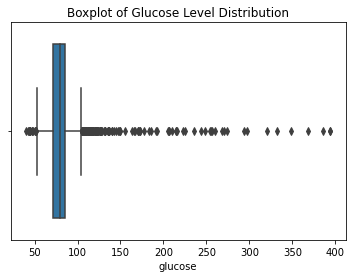

In [59]:
#graph distribution of glucose levels
sns.boxplot(df.glucose)
plt.title('Boxplot of Glucose Level Distribution');

Now that we have dealt with all missing values, we will now look at a pairplot of the continuous variables to try and capture some relationships between the variables. We will also be highlighting the target variable.

In [60]:
#getting a list of continous variable columns
cont_columns = []
for i in df.columns:
    if df[i].dtype !='object':
        cont_columns.append(i)

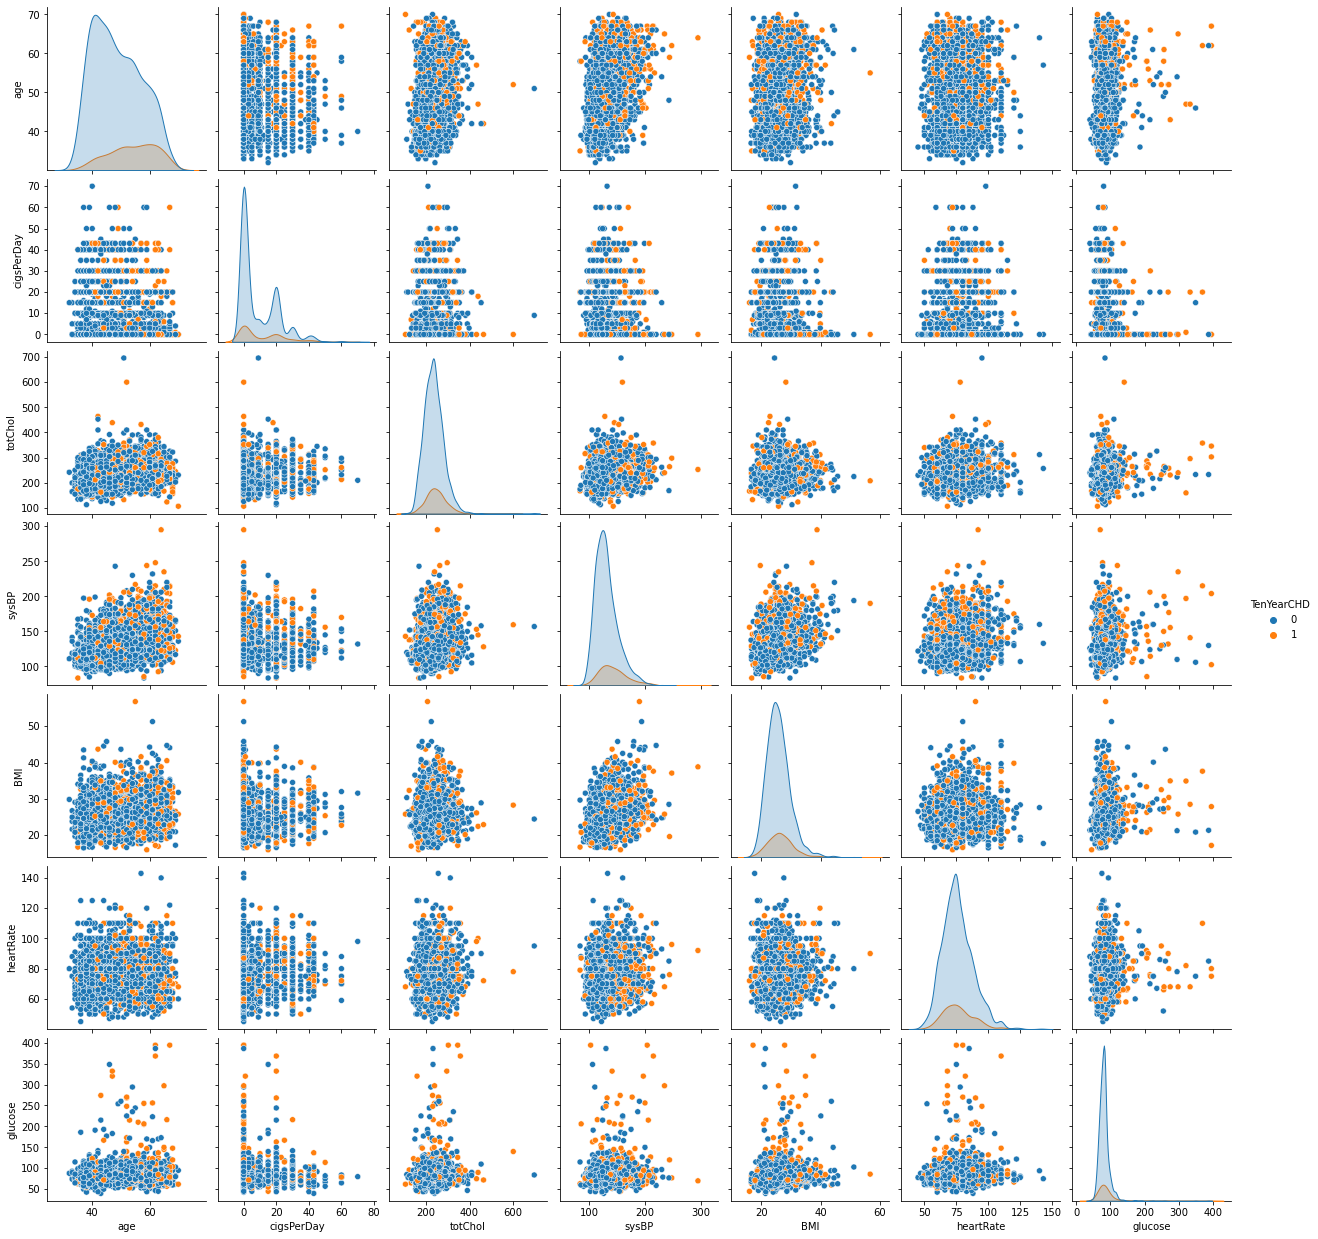

In [61]:
#checking the distributions of the continous variables with a hue of CHD
sns.pairplot(df[cont_columns], hue='TenYearCHD');

From this pairplot we can see some interesting relationships between the variables. The patterns we observed include:

- The relation between age and glucose - There is a high amount of At Risk patients in the top right quadrant with high age and high glucose.

- The relation between systolic BP and glucose - In nature, high glucose is often associated with high blood pressure. This association makes us wonder if the combination of the two prove to be influential in patients at risk for CHD. 

- The relationship between cholesterol and glucose - There seems to be a slight separation between the groups that are At Risk and those that are not.

We have plotted these relationships below:

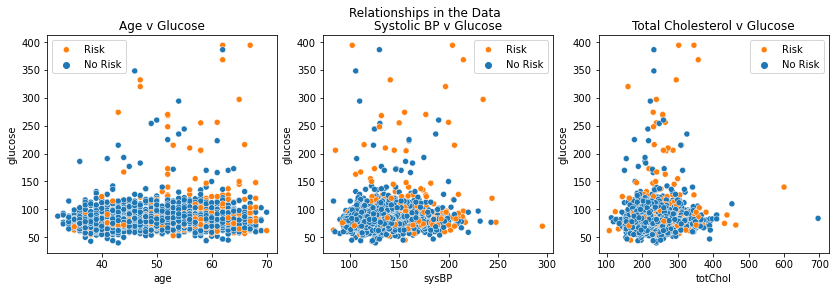

In [62]:
#plotting our interesting relationships from the pairplot
legend_label = ['Risk', 'No Risk']
fig, ax = plt.subplots(1, 3, figsize=(14,4))
fig.suptitle('Relationships in the Data')
sns.scatterplot(x=df.age, y=df.glucose, ax=ax[0], hue = df.TenYearCHD)
ax[0].set_title('Age v Glucose')
ax[0].legend(legend_label)
sns.scatterplot(x=df.sysBP, y=df.glucose, ax=ax[1], hue = df.TenYearCHD)
ax[1].set_title('Systolic BP v Glucose')
ax[1].legend(legend_label)
sns.scatterplot(x=df.totChol, y=df.glucose, ax=ax[2], hue = df.TenYearCHD)
ax[2].set_title('Total Cholesterol v Glucose')
ax[2].legend(legend_label)
plt.savefig('Images/Data_Relations');

We are interested in investigating these ideas further, so we will be engineering features inspired by our observations.

------------------------------------------------------------------------------------------------------------------

# Feature Engineering

*age_4  -- binned age groups*

In [63]:
#binning the ages by every 4 years
df['age_4'] = pd.cut(x=df['age'], bins=list(range(32,70,4)))

In [64]:
df['age_4'].head(2)

0    (60, 64]
1    (32, 36]
Name: age_4, dtype: category
Categories (9, interval[int64]): [(32, 36] < (36, 40] < (40, 44] < (44, 48] ... (52, 56] < (56, 60] < (60, 64] < (64, 68]]

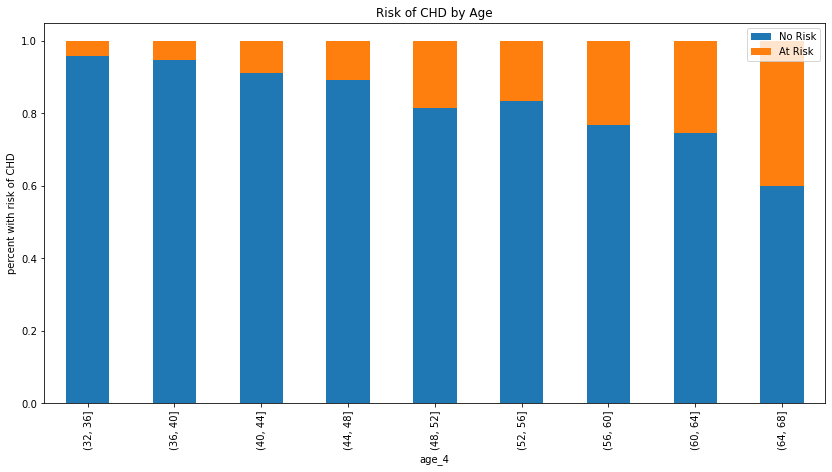

In [65]:
#looking at a barplot for the binned age variable
fig, ax = plt.subplots(figsize=(14,7))
df.groupby('age_4')['TenYearCHD'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('percent with risk of CHD')
ax.set_title('Risk of CHD by Age')
ax.legend(legend_labels);

Binning our age groups only further demonstrates that the risk of CHD increases with age.

-------------------------------------------------

*age_and_glucose -- polynomial feature between age and glucose level*

In [66]:
df.TenYearCHD.mean()

0.15073746312684366

In [67]:
df[(df.age >= 50) & (df.glucose >= 140)].TenYearCHD.mean()

0.6052631578947368

We can see that those over 50 years old with a glucose level greater than 140 capture 60% of the individuals at risk for CHD.

In [68]:
#getting a list of indice for participants with this criteria
idx = list(df[(df.age >= 50) & (df.glucose >= 140)].index)

#creating a new column
df['age_and_glucose']= np.array([0 for i in range(len(df))])

#changing the 0 value for those indices to 1
df['age_and_glucose'][idx] = 1

-----------------------------------------------

*sysBP_and_glucose -- polynomial feature between systolic BP and glucose level*

In [69]:
df[(df.sysBP >= 120) & (df.glucose >= 140)].TenYearCHD.mean()

0.5116279069767442

This filtering captures 51% of patients in the data at risk for CHD.

In [70]:
#getting a list of indices for the paricipants with this criteria
idx = list(df[(df.sysBP >= 120) & (df.glucose >= 140)].index)

#creating a new column
df['sysBP_and_glucose']= np.array([0 for i in range(len(df))])

#changing the 0 value for those indices to 1
df['sysBP_and_glucose'][idx] = 1

--------------------------------------------------------

*totChol_and_glucose -- polynomial feature between cholesterol level and glucose level*

In [71]:
df[(df.totChol >= 200) & (df.glucose >= 140)].TenYearCHD.mean()

0.5681818181818182

This feature with that particular filtering captures 56% of the patients at risk for CHD.

In [72]:
#getting a list of indices for the paricipants with this criteria
idx = len(df[(df.totChol >= 200) & (df.glucose >= 140)])


#creating a new column
df['totChol_and_glucose']= np.array([0 for i in range(len(df))])

#changing the 0 value for those indices to 1
df['totChol_and_glucose'][idx] = 1

-------------------------------

# Getting Dummies for Categorical Columns

In [73]:
df.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'BMI', 'heartRate', 'glucose', 'TenYearCHD', 'age_4', 'age_and_glucose',
       'sysBP_and_glucose', 'totChol_and_glucose'],
      dtype='object')

In [74]:
#getting a new DataFrame with our dummied variables
df = pd.get_dummies(df, columns = ['age_4', 'education'], drop_first = True)

-------------------------------

# Implementing Oversampling for this Unbalanced Dataset

Of all the techniques for dealing with unbalanced datasets, we decided to go with oversampling. This dataset is on the smaller side, and we figured this option would be better than SMOTE because we wouldn't want the data generated from SMOTE to possibly reflect any inaccuracies.

In [75]:
from sklearn.utils import resample


#this is the minority class,  we will oversample this  

chd_positive = df[df.TenYearCHD == 1]

#getting the length of the majority
len(df[df.TenYearCHD == 0])

2879

In [76]:
# upsample minority
chd_positive_upsampled = resample(chd_positive, replace=True, # sample with replacement
                        n_samples=len(df[df.TenYearCHD == 0]), # match number in majority class
                        random_state = 23) # reproducible results

In [77]:
df.TenYearCHD.value_counts()

0    2879
1     511
Name: TenYearCHD, dtype: int64

We are validating that the original DataFrame has been modified below and that the target variable is now evenly balanced. See below:

In [78]:
# combine majority and upsampled minority
upsampled = pd.concat([df[df.TenYearCHD == 0], chd_positive_upsampled])

# check new class counts
upsampled.TenYearCHD.value_counts()

1    2879
0    2879
Name: TenYearCHD, dtype: int64

----------------------------------------------------

# Further Model Preparation & Selection

In [79]:
#Splitting the data into train_test_split
from sklearn.model_selection import train_test_split

#separating the target variable
X = upsampled.drop(['TenYearCHD'], axis = 1)

#isolating the target variable
y = upsampled.TenYearCHD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [80]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [81]:
#getting the new scaled DataFrames with the TRANSFORMED data
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index)

X_test_scale = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

Because we are seeking to single out factors in determining the risk of CHD, we have decided for our modelling process to look at the possibilites of a Logistic Regression or Decision Tree/Random Forest Classifier Model. We believe their interpretabilities would lead us to our best results. The metric we are seeking for comparison is the recall score because a False negative in this situation would be worse than a False positive.

-----------------------------------------------

# MODELING

# Logistic Regression

### Initial Log Model

In [82]:
from sklearn.linear_model import LogisticRegression

#instantiation Logistic Regression
logreg = LogisticRegression(random_state=42)

#fitting the model
logreg.fit(X_train_scale,y_train)

LogisticRegression(random_state=42)

In [83]:
#importing cross validaton
from sklearn.model_selection import cross_val_score

#creating a custom scorer for recall
from sklearn.metrics import make_scorer, recall_score
custom_scorer = make_scorer(recall_score, pos_label= 1)

#getting the cross val recall score
log_cv = cross_val_score(logreg, X_train_scale, y_train, scoring = custom_scorer, cv = 3)
print(log_cv)

[0.65588616 0.69559585 0.69081501]


In [84]:
#getting predictions
logreg_pred = logreg.predict(X_test_scale)
logreg_pred[:5]

array([1, 1, 1, 0, 1])

In [85]:
from sklearn.metrics import classification_report, confusion_matrix

#getting our confusion matrix and classification report
print(confusion_matrix(y_test, logreg_pred))
print(classification_report(y_test,logreg_pred))

[[396 195]
 [176 385]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       591
           1       0.66      0.69      0.67       561

    accuracy                           0.68      1152
   macro avg       0.68      0.68      0.68      1152
weighted avg       0.68      0.68      0.68      1152



The recall score for this model is .69. This was only our first attempt a model. We plan on taking other steps to improve our score and obtain a better model.

Now we will try some Random Search cross validation to try for an improvement.

## Random Search Cross Validation with Logistic Regression

In [86]:
import scipy.stats as stats

from sklearn.model_selection import cross_val_score, RandomizedSearchCV

#creating a parameter dict
rs_grid = {'C': stats.uniform(loc=0, scale=10),
               'l1_ratio': stats.expon(scale=0.2)}

#instantiation RandomSearchCV with parameters
rs = RandomizedSearchCV(estimator=LogisticRegression(penalty='elasticnet',
                                                    solver='saga',
                                                    max_iter=1000,
                                                    random_state=42),
                        param_distributions=rs_grid, scoring = custom_scorer,
                       random_state=42)

rs.fit(X_train_scale, y_train)

#getting the best parameters
rs.best_params_

{'C': 0.5808361216819946, 'l1_ratio': 0.4022461728959879}

In [87]:
#getting the best recall score
rs.best_score_

0.6833441945334029

Random Search did not prove to increase the recall. This model would not be better than our original one. We will attempt to utilize Grid Search as another way for model optimization.

## Grid Search with Logistic Regression

In [88]:
from sklearn.model_selection import GridSearchCV

#getting a dict of parameters
grid = {'random_state': [42],
    'penalty':['l1', 'l2', 'elasticnet', None],
    'C': [.001, .01, .1, 1.0],
    'class_weight':[None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#instantiating GridSearch model
gs = GridSearchCV(estimator=logreg, param_grid=grid, cv=5, scoring = custom_scorer)

#fitting the GridSearch model
gs.fit(X_train_scale, y_train)



GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(recall_score, pos_label=1))

In [89]:
#getting the best parameters
gs.best_params_

{'C': 0.001,
 'class_weight': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'saga'}

In [90]:
#getting the best recall score
gs.best_score_

1.0

Unlike our efforts with Random Search, Grid Search has given us an improvement in the score. We shall take this improvement and generate a new model from these Grid Search results. 

### New Log Model

In [91]:
#instantiating Logistic Regression with our grid search parameters
gslog = LogisticRegression(C= 0.001,
 class_weight= None,
 penalty= 'l2',
 random_state= 42,
 solver= 'newton-cg')

#fitting the model
gslog.fit(X_train_scale,y_train)

LogisticRegression(C=0.001, random_state=42, solver='newton-cg')

In [92]:
#retrieving cross validation scores
gslog_cv = cross_val_score(gslog, X_train_scale, y_train, scoring = custom_scorer, cv = 3)
print(gslog_cv)

[0.69857697 0.72927461 0.71021992]


In [93]:
#getting predictions
gslog_pred = gslog.predict(X_test_scale)
gslog_pred[:5]

array([1, 1, 1, 0, 1])

In [94]:
#getting confusion matrix and classification reports
print(confusion_matrix(y_test, gslog_pred))
print(classification_report(y_test,gslog_pred))

[[394 197]
 [175 386]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       591
           1       0.66      0.69      0.67       561

    accuracy                           0.68      1152
   macro avg       0.68      0.68      0.68      1152
weighted avg       0.68      0.68      0.68      1152



Grid Search has proved to be a bit misleading. The recall score has only improved slightly. Nevertheless, now that we have an improvement, we will take this model and look at the coefficients. We are seeking to identify the ones with the strongest magnitude as that will influence our conclusions.

In [95]:
#creating a dict of coefficients and variables
coefficients = dict(zip(list(gslog.coef_[0]), X_test_scale))

In [96]:
#creating a sorted list of coefficients
coef_list = sorted(coefficients, reverse = True)

var=[]
coef=[]
for i in coef_list:
    var.append(coefficients[i]) 
    coef.append(i)

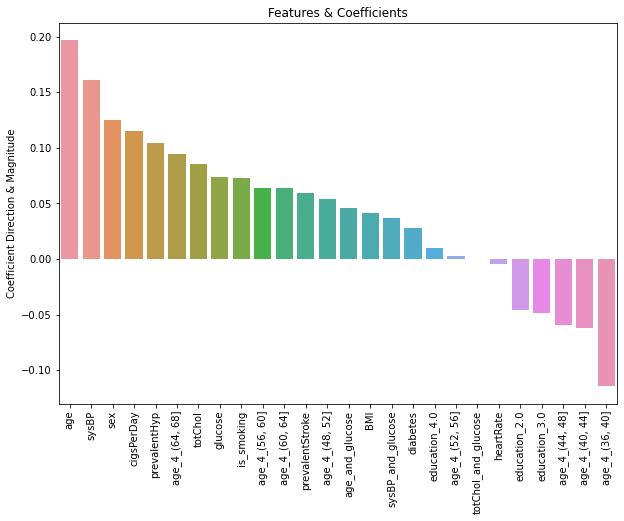

In [97]:
#graphing the coefficients of our features
labels = var
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x = var, y = coef)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Coefficient Direction & Magnitude')
ax.set_title('Features & Coefficients');

From the graph above we can now identify the most influential coefficients by both direction and magnitude. We shall now continue along with the modelling process as we have yet to try a decision tree model.

-----------------------------------------------------------------------------------------

# Decision Tree

In [98]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

In [99]:
#instantiating DecisionTree and setting it to an arbitrary max_depth as an initial effort
dt = DecisionTreeClassifier(criterion='entropy', max_depth = 2, random_state=42)

#fitting the model below

#we have chosen not to scale the data because Decision Trees are not sensitive to variance in the data.
dtree = dt.fit(X_train, y_train) 


In [100]:
#getting dtree cross validation
dtree_cv = cross_val_score(dtree, X_train, y_train, scoring = custom_scorer, cv = 3)
print(dtree_cv)

[0.80336352 0.82642487 0.86545925]


In [101]:
#getting predicted scores
dtree_pred = dtree.predict(X_test)
dtree_pred[:5]

array([1, 1, 1, 0, 1])

In [102]:
#printing confusion matrix and classification report
print(confusion_matrix(y_test, dtree_pred))
print(classification_report(y_test,dtree_pred))

[[282 309]
 [116 445]]
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       591
           1       0.59      0.79      0.68       561

    accuracy                           0.63      1152
   macro avg       0.65      0.64      0.62      1152
weighted avg       0.65      0.63      0.62      1152



This is a better recall score than any of our Logistic Regression models. However, comparing the recall to the cross validation scores, the model may be overfit. It is performing better on the train set than it is on the test set. Let's try to improve this. Clearly we need to increase the depth of this tree. Below we will utilize a function to calculate a more ideal depth.

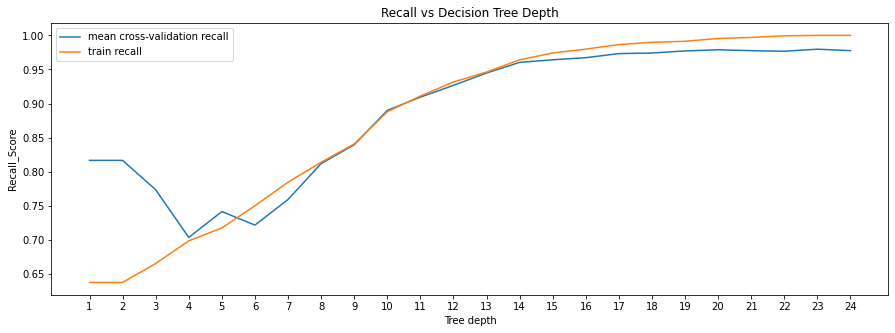

In [103]:
# creating a function for cross-validation of trees with a range of depths
def cross_validation_scores_on_trees(X, y, tree_depths, cv, scoring):
    """
    This function performs cross validation for recall on the decision trees 
    for a range of depths. 
    """
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    recall_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        recall_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    recall_scores = np.array(recall_scores)
    return cv_scores_mean, cv_scores_std, recall_scores

#getting a list of desired depths
depths = list(range(1,25))

#unpacking the function to access each deliverable separately
cv_scores_mean, cv_scores_std, recall_scores = cross_validation_scores_on_trees(X_train, y_train, depths, 5, custom_scorer)

#plotting the ideal depth for decision tree
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(depths, cv_scores_mean)
ax.plot(depths, recall_scores)
ax.set_title('Recall vs Decision Tree Depth')
ax.set_xlabel('Tree depth')
ax.set_ylabel('Recall_Score')
ax.set_xticks(depths)
ax.legend(['mean cross-validation recall', 'train recall']);

We have decided to execute a model with a tree depth of 17. It gives us a good recall score and does not seem to overfit the data like our previous model. Below we will create this model for further analysis.

In [104]:
#instantiating Decision Tree with the new max_depth
dt = DecisionTreeClassifier(criterion='entropy', max_depth = 17, random_state=42)

#fitting the model
dtree17 = dt.fit(X_train, y_train)

In [105]:
#getting cross validation scores
dtree17_cv = cross_val_score(dtree17, X_train, y_train, scoring = custom_scorer, cv = 3)
print(dtree_cv)

[0.80336352 0.82642487 0.86545925]


In [106]:
#getting predictions
dtree17_pred = dtree17.predict(X_test)
dtree17_pred[:5]

array([1, 1, 1, 1, 1])

In [107]:
#getting confusion matrix and classification report
print(confusion_matrix(y_test, dtree17_pred))
print(classification_report(y_test,dtree17_pred))

[[461 130]
 [ 14 547]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       591
           1       0.81      0.98      0.88       561

    accuracy                           0.88      1152
   macro avg       0.89      0.88      0.87      1152
weighted avg       0.89      0.88      0.87      1152



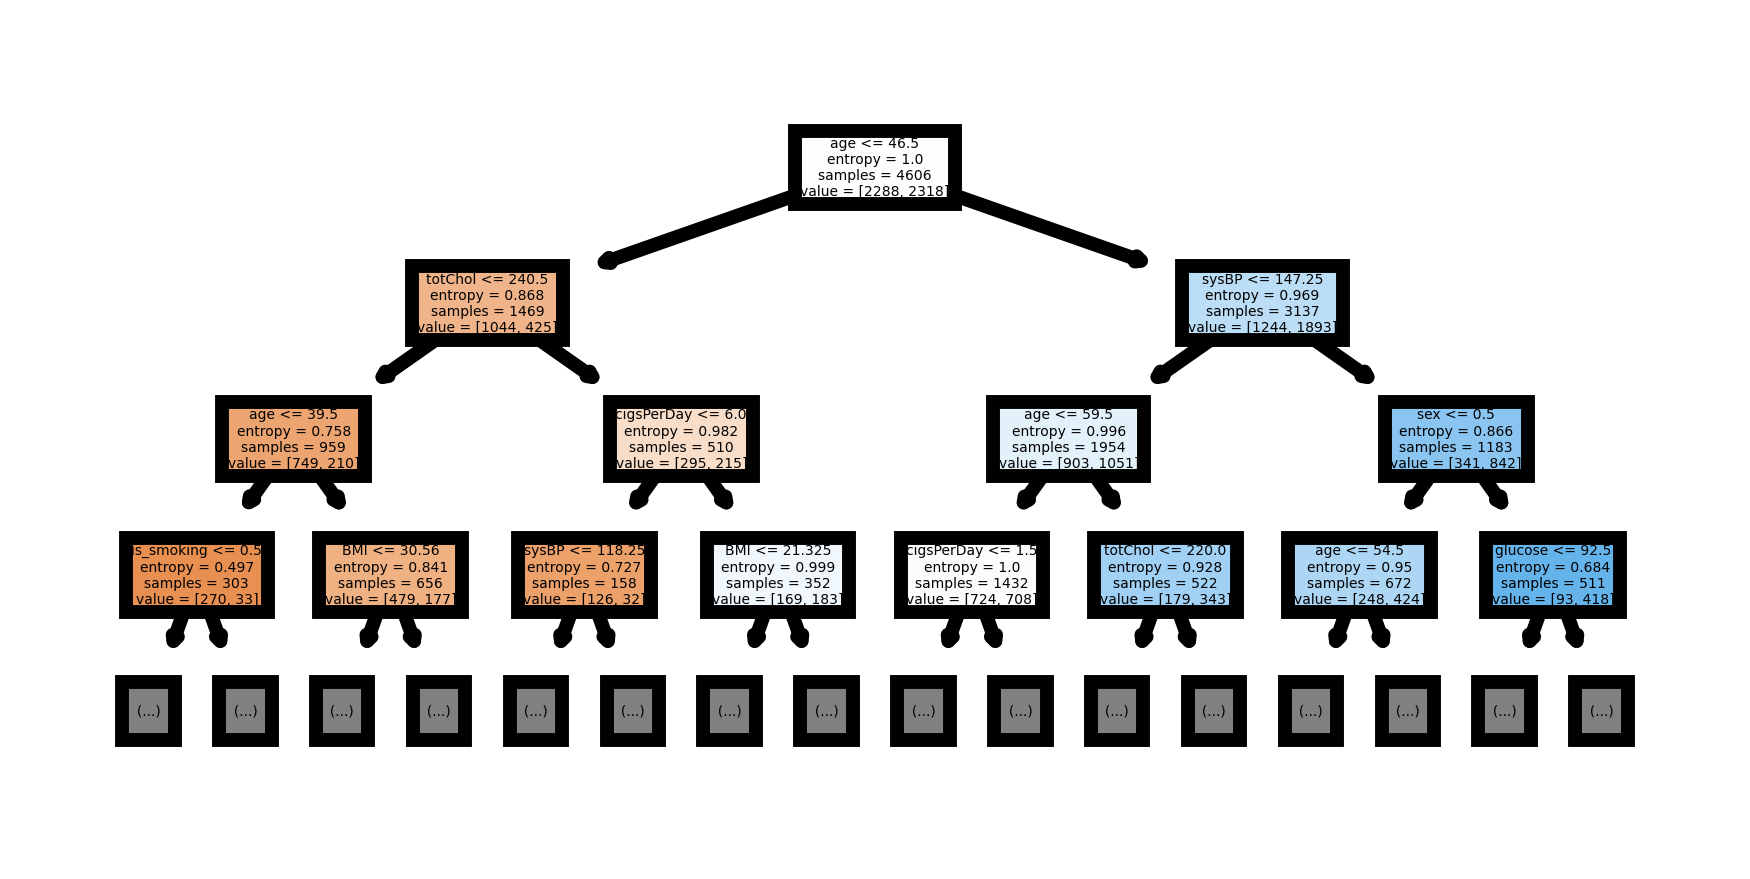

In [108]:
#plotting the tree
fig, ax = plt.subplots(figsize = (2, .9), dpi = 1000)
plot_tree(dtree17, max_depth= 3, feature_names=X.columns, filled=True)
plt.savefig('Images/dtree17');

This is the highest recall score we have seen so far. We decided to look tree diagram above to take a look at the tree's evaluation process. Additionally we are going to take a look at the coefficients below:

In [109]:
#creating a dict of coefficients and variables
features = dict(zip(list(dtree17.feature_importances_), X_test))

In [110]:
#creating a sorted list of coefficients
feat_list = sorted(features, reverse = True)

var=[]
feat=[]
for i in feat_list:
    var.append(features[i]) 
    feat.append(i)

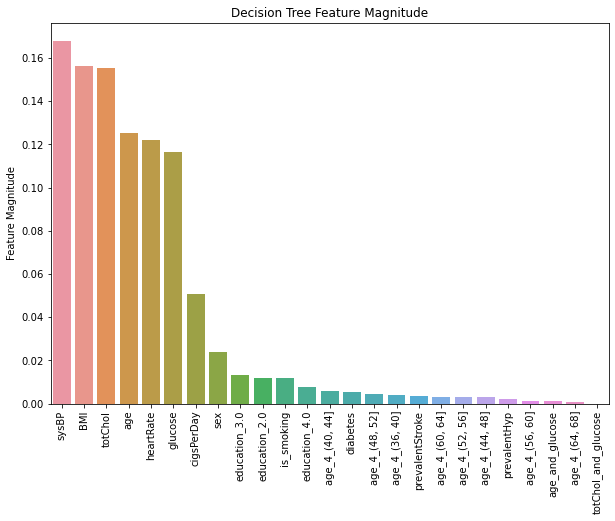

In [111]:
#graphing the features by magnitude
labels = var
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x = var, y = feat)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Feature Magnitude')
ax.set_title('Decision Tree Feature Magnitude')
plt.savefig('Images/DecTree17Magnitude');

In the graph above, we can see the magnitude of our coefficients. It seems that our engineered features have not made the cut into the top 7. Albeit that, this seems like a pretty solid model. We are going to attempt a Random Forest to see what it can do for our further understanding.

-----------------------------

# Random Forests 

In [112]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate an RandomForestClassifier
rf = RandomForestClassifier(max_features='sqrt',
                         max_samples=0.5,
                         bootstrap=True,
                         random_state=42)

#fitting the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, random_state=42)

In [113]:
#getting cross validation scores
rf_cv = cross_val_score(rf, X_train, y_train, scoring = custom_scorer, cv = 3)
print(rf_cv)

[0.94825356 0.95595855 0.93531695]


In [114]:
#getting predictions
rf_pred = rf.predict(X_test)
rf_pred[:5]

array([1, 1, 1, 1, 1])

In [115]:
#getting confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test,rf_pred))

[[537  54]
 [ 11 550]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       591
           1       0.91      0.98      0.94       561

    accuracy                           0.94      1152
   macro avg       0.95      0.94      0.94      1152
weighted avg       0.95      0.94      0.94      1152



The recall score is about the same as the decision tree. From the cross validation scores we can see that the model is not overfit. Lets now take a look at the coefficients.

In [116]:
#creating a dict of coefficients and variables
rffeatures = dict(zip(list(rf.feature_importances_), X_test))

In [117]:
#creating a sorted list of coefficients
rffeat_list = sorted(rffeatures, reverse = True)

rfvar=[]
rffeat=[]
for i in rffeat_list:
    rfvar.append(rffeatures[i]) 
    rffeat.append(i)

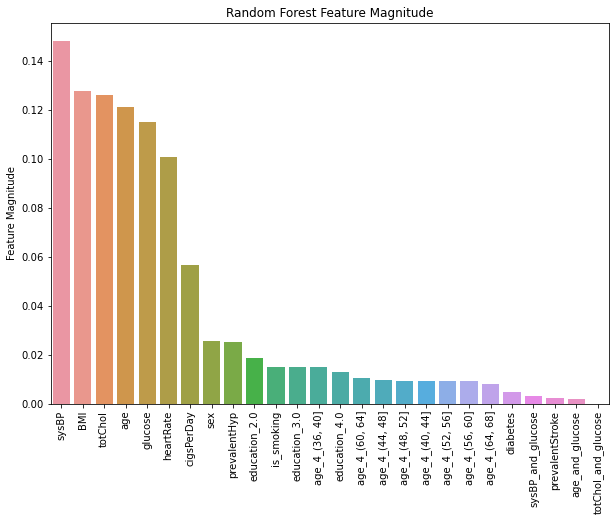

In [118]:
#graphing the random forest features
labels = rfvar
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x = rfvar, y = rffeat)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Feature Magnitude')
ax.set_title('Random Forest Feature Magnitude');

These are the features, according the Random Forest that have the greatest magnitude. We believe this is also a good contender for a model. Now that we have a couple of solid models, we think we can look at their scores side by side to make our decision.

---------------------------------------

# Model Decision

In [119]:
#creating a table of our final models and their recall scores
model_score_dict = {'Models':['New Log Model', 'Decision Tree 17', 'Random Forest'],
                    'Recall Scores':[round(recall_score(y_test, gslog_pred),2),
                                    round(recall_score(y_test, dtree17_pred),2),
                                    round(recall_score(y_test, rf_pred),2)]}
pd.DataFrame(model_score_dict)

,Models,Recall Scores
0,New Log Model,0.69
1,Decision Tree 17,0.98
2,Random Forest,0.98


For our final model, we decided to go with the Decision Tree. The recall scores were just as high as the Random Forest, however, Decision Trees are easier to interpret. We can not only get the magnitude of our coefficients, we can get a visualization of the Decision Tree to see its process. This will allow us to reach our understanding of the populations at risk for CHD.